In [2]:
import requests
import json
import re 
import csv
import os
import gensim
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import Word2Vec 
from scipy.stats import pearsonr
from nltk.corpus import wordnet
from os import path
from functools import reduce, partial
from itertools import starmap
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize

In [2]:
# Download resources for NLTK 
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ThinkPad\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ThinkPad\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ThinkPad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Datasets

In [3]:
def datamuse(query):
    # http://www.datamuse.com/api/
    url = "https://api.datamuse.com/words?ml=" + query + "&max=75" #max = number of results to return
    response = requests.get(url)
    similar_words = [x['word'] for x in json.loads(response.content)]
    return similar_words

In [4]:
def load_sim_eval(name):
    with open('datasets/sim-eval-master/datasets/{name}.csv'.format(name=name), newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=';')
        rows = []
        for row in reader: rows.append(row)
        return rows # [[word1, word2, similarity], ...] 

In [5]:
def load_stss131():
    # https://www.researchgate.net/publication/262411640_A_new_benchmark_dataset_with_production_methodology_for_short_text_semantic_similarity_algorithms
    with open('datasets/stss-131/stss.csv', newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=';')
        rows = []
        for row in reader: rows.append(row)
        return rows # [[index, sentence1, sentence2, avg similarity, standard deviation], ...]

# Similarity measures

In [6]:
def jaccard_similarity(word_list1, word_list2):
    if (len(word_list1) == 0 and len(word_list2) == 0): return 1
    intersection = len(set(word_list1).intersection(word_list2))
    union = len(set(word_list1).union(word_list2))
    return intersection / union

def word2vec_similarity(word_list1, word_list2):
    return

def glove_similarity(word_list1, word_list2):
    # import glove
    # Available glove datasets
    #glove.GLOVE_DATASETS
    # Select the dataset
    #ds = glove.GLOVE_DATASETS['50d']
    # Load the dataset to pandas dataframe
    #words = glove.load_words(ds)
    # Get one
    # words.loc['morning']
    # Get multiple
    #words.loc[['morning','peth']]
    return

def fasttext_similarity(word_list1, word_list2):
    return

def yago_similarity(word_list1, word_list2):
    return

def dbpedia_similarity(word_list1, word_list2):
    return

# Write Datamuse output to files

In [7]:
def get_ml(w,c):
    """ Get a function for querying the related words """
    return [lambda: datamuse(
       "{word}&max={count}"
       .format(word=w,count=c)
    ), w]

def relations_to_file(fn, word):
    """
    fn: query function
    word
    """
    filename = "./related-words/{}.ml".format(word)
        
    with open(filename, 'w') as f:
        """ 
        Query the related words one at a time 
        when required for writing to file 
        """
        for word in fn():
            f.write(word)
            f.write('\n')
            
    return filename

def collect_ml_getters(dataset_fn, count=100):
    """ Collect the getters for lazy evaluation """
    return reduce(lambda acc, fns: acc + fns, [
        [get_ml(f,count), get_ml(s,count)]
        for f, s, _ 
        in dataset_fn()
    ], [])

def get_and_write_dataset_words_to_files(dataset_fn, count):
    """works for files that return tuple with three items per row"""
    return list(starmap(
        relations_to_file, 
        collect_ml_getters(dataset_fn, count)
    ))

def get_ml_to_file(wordlist, count=25):
    collected_getters = [get_ml(w, count) for w in list(wordlist)]
    return list(starmap(relations_to_file, collected_getters))

# write sim-eval files with
# get_and_write_dataset_words_to_files(lambda: load_sim_eval("mc"), count=100)
# get_and_write_dataset_words_to_files(lambda: load_sim_eval("rg"), count=100)
# get_and_write_dataset_words_to_files(lambda: load_sim_eval("wordsim"), count=100)

In [8]:
def get_all_tokens(list_of_sentences):
    return reduce(
        lambda a,t: a +t, 
        [word_tokenize(s) 
         for s 
         in list_of_sentences],
        []
    )

def clean_token(word):
    clean1 = re.sub('^[^a-zA-Z]*', "", word)
    clean2 = re.sub('[€0-9â™©]',"", clean1)
    return re.sub('[^a-zA-Z]*$', "", clean2).lower()

data = pd.DataFrame(load_stss131(), columns=['0', 's1','s2','similarity','4']).drop(columns=['0', '4'])
stss131_all_sentences = data['s1'] + ' ' + data['s2']
stss131_uniq_tokens = list(
    set(reduce(
        lambda a,w: a+w,
        [
            w.split('.') 
            for w 
            in get_all_tokens(stss131_all_sentences)], 
        []
    )
))
stopwords = nltk.corpus.stopwords.words('english')
for word in stopwords:
    if "'" in word:
        stopwords.append(word.replace("'", "")) 
stopwords.append("n't")
stemmer = nltk.stem.snowball.SnowballStemmer('english')
a = set(stss131_uniq_tokens)
b = set(stopwords)
stss131_without_stopwords = list(a.difference(b))
stss131_without_stopwords = set(stss131_uniq_tokens).difference(set(stopwords))
cleaned_tokens = [clean_token(w) for w in stss131_without_stopwords]
cleaned_without_empty = [w for w in cleaned_tokens if len(w) > 0]
duplicates_removed = list(set(cleaned_without_empty))
downloaded = set([w.replace('.ml', '').lower() for w in os.listdir('./related-words')])
stss131_unique_cleaned_tokens = list(set(duplicates_removed).difference(set(downloaded)).difference(set(stopwords)))

# write stss131 files with
# get_ml_to_file(stss131_unique_cleaned_tokens, count=100)

In [9]:
def related_words(word):
    path = './related-words/'+word+'.ml'
    if (os.path.isfile(path)):
        with open(path, 'r') as f:
            return np.array([ l.replace("\n", "") for l in f])      
    else:
        return np.array([])
    
# load the related words with
# related_words("automobile")

# Correlation

In [11]:
def calc_sim_eval_correlation(data):
    def f(number_of_outputs):
        similarity = lambda row: jaccard_similarity(
            related_words(row[0])[:number_of_outputs], 
            related_words(row[1])[:number_of_outputs]
        )
        datamuse_similarity = np.apply_along_axis(similarity, 1, data)
        ground_truth = data.transpose()[2].astype(np.float)
        return pearsonr(datamuse_similarity, ground_truth)[0]
    return f

Text(0, 0.5, 'Correlation')

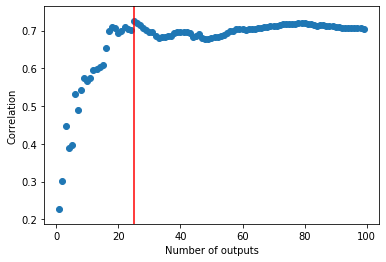

In [11]:
# MC
n = np.arange(1, 100, 1)
corr = np.vectorize(calc_sim_eval_correlation(np.array(load_sim_eval("mc"))))(n)
plt.scatter(n, corr)
plt.axvline(x=n[np.argmax(corr)], color="red")
plt.xlabel("Number of outputs")
plt.ylabel("Correlation")

Text(0, 0.5, 'Correlation')

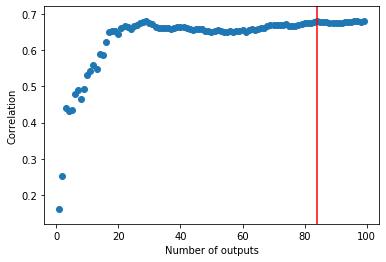

In [12]:
# RG 
n = np.arange(1, 100, 1)
corr = np.vectorize(calc_sim_eval_correlation(np.array(load_sim_eval("rg"))))(n)
plt.scatter(n, corr)
plt.axvline(x=n[np.argmax(corr)], color="red")
plt.xlabel("Number of outputs")
plt.ylabel("Correlation")

In [12]:
# wordsim 
n = np.arange(1, 100, 1)
#corr = np.vectorize(calc_sim_eval_correlation(np.array(load_sim_eval("wordsim"))))(n)
#plt.scatter(n, corr)
#plt.axvline(x=n[np.argmax(corr)], color="red")
#plt.xlabel("Number of outputs")
#plt.ylabel("Correlation")
print(calc_sim_eval_correlation(np.array(load_sim_eval("wordsim")))(25))

0.3653332576134618


Text(0, 0.5, 'Correlation')

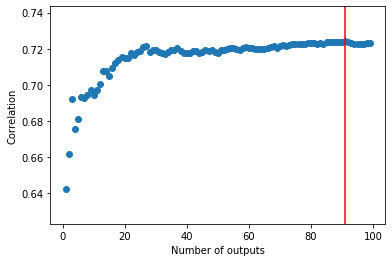

In [14]:
# stss131 

stss131_valid_tokens = list(filter(lambda x: len(x) > 2, set(duplicates_removed).difference(set(stopwords))))

def sentence_to_related_words_union(sent, number_of_outputs):
    tokens = list(set([clean_token(x) for x in sent.split(' ') if (clean_token(x) in stss131_valid_tokens)]))
    rel_words_union = list(set([x for l in map(related_words, tokens) for x in l[:number_of_outputs]]))
    return np.array(list(set(tokens + rel_words_union)))
   
def sentence_to_related_words_overlap(sent, number_of_outputs):
    tokens = list(set([clean_token(x) for x in sent.split(' ') if (clean_token(x) in stss131_valid_tokens)]))
    rel_words = list(map(lambda w: related_words(w)[:number_of_outputs], tokens))
    rel_words_intersected = list(set(rel_words[0]).intersection(*rel_words))
    return np.array(list(set(tokens + rel_words_intersected)))
        
def calc_stss131_correlation(number_of_outputs):
    data = np.array(load_stss131())
    similarity = lambda row: jaccard_similarity(
        sentence_to_related_words_union(row[1], number_of_outputs), 
        sentence_to_related_words_union(row[2], number_of_outputs)
    )
    datamuse_similarity = np.apply_along_axis(similarity, 1, data)
    ground_truth = data.transpose()[3].astype(np.float)
    return pearsonr(datamuse_similarity, ground_truth)[0]

n = np.arange(1, 100, 1)
corr = np.vectorize(calc_stss131_correlation)(n)
plt.scatter(n, corr)
plt.axvline(x=n[np.argmax(corr)], color="red")
plt.xlabel("Number of outputs")
plt.ylabel("Correlation")

# Random stuff

In [15]:
uniq_wordsim = set(reduce(lambda x,y: x + y, [ [a,b] for a,b,x in wordsim ], []))
collected_getters = [get_ml(w, 25) for w in list(uniq_wordsim)]

def load_unique_words_to_file(name):
    uniq_wordsim = set(reduce(lambda x,y: x + y, [ [a,b] for a,b,x in load_dataset(name) ], []))
    get_ml_to_file(uniq_wordsim)
    
load_unique_words_to_file('rg')

NameError: name 'wordsim' is not defined

In [ ]:
list(
    set(duplicates_removed).difference(set(downloaded)).difference(set(stopwords)))

In [ ]:
def tokenize_sentence(sentence, stopwords):
    tokens = [w for w in [clean_token(t) for t in word_tokenize(sentence)] if len(w) > 0]
    #return tokens
    return list(set(tokens).difference(stopwords))

In [ ]:
def pad_a(arr, c=25, padwith=None):
    if (len(arr) == 25):
        return arr
    else:
        return np.array(arr) + np.array([padwith]) * (c-len(arr))

In [ ]:
def pad_a(arr, c=25, padwith=None):
    return np.array(arr) + np.array([padwith]) * (c-len(arr))

In [ ]:
def pad_a(arr, c=25, padwith=None):
    return arr + [padwith] * (c-len(arr))

In [15]:
google_vectors = './GoogleNews-vectors-negative300.bin'
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format(google_vectors, binary=True)